In [1]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from PIL import Image

MODEL_PATH = '../models_segmantation/unet_segmentation_ckp.keras'
assert os.path.exists(MODEL_PATH), "Model file not found"
SRC_DIR = './src_data_unet' # Images from src_data resized to 128x128
assert os.path.exists(SRC_DIR), "Source directory not found"
DESTINATION_DIR = './segmented_data'
os.makedirs(DESTINATION_DIR, exist_ok=True)
CLASSES = ['rock', 'paper', 'scissors']
img_size = (128, 128)

def load_images(src_dir):
    image_paths = [os.path.join(src_dir, fname) for fname in os.listdir(src_dir)]
    images = []
    filenames = []
    
    for img_path in image_paths:
        img = load_img(img_path, target_size=img_size)
        img = img_to_array(img) / 255.0  
        images.append(img)
        filenames.append(os.path.basename(img_path))  
    return np.array(images), filenames

model = load_model(MODEL_PATH)

for class_name in CLASSES:
    total_predictions = 0
    print(f"Segmenting images from class {class_name}")
    
    image_dir = os.path.join(SRC_DIR, class_name)  
    output_dir = os.path.join(DESTINATION_DIR, class_name)  
    os.makedirs(output_dir, exist_ok=True)
    
    images, filenames = load_images(image_dir)
    
    predictions = model.predict(images)
    
    for pred, fname in zip(predictions, filenames):

        pred_mask = (pred.squeeze() > 0.5).astype(np.uint8) * 255 
        
        
        mask_image = Image.fromarray(pred_mask)
        mask_image = mask_image.convert("L")  
        output_path = os.path.join(output_dir, fname.replace('.jpg', '.png').replace('.jpeg', '.png')) 
        mask_image.save(output_path, format='PNG')
        total_predictions += 1
        
    print(f"Segmented {total_predictions} images from class {class_name}")


Segmenting images from class rock
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 133ms/step
Segmented 2389 images from class rock
Segmenting images from class paper
76/76 ━━━━━━━━━━━━━━━━━━━━ 10s 136ms/step
Segmented 2409 images from class paper
Segmenting images from class scissors
76/76 ━━━━━━━━━━━━━━━━━━━━ 30s 398ms/step
Segmented 2430 images from class scissors


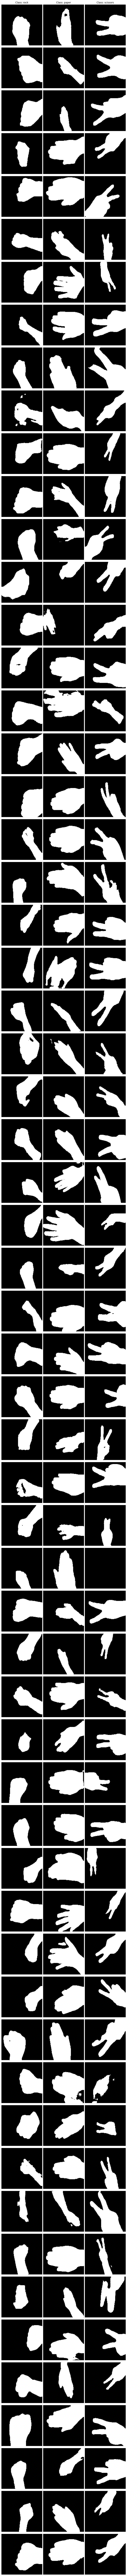

In [2]:
import matplotlib.pyplot as plt
import random
from PIL import Image

def visualize_random_images(src_dir, classes, num_images=5):
    num_cols = len(classes)
    num_rows = num_images
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 3, num_rows * 3))
    
    for i, class_name in enumerate(classes):
        class_dir = os.path.join(src_dir, class_name)
        image_files = os.listdir(class_dir)
        random_files = random.sample(image_files, min(num_images, len(image_files)))
        
        for j, img_file in enumerate(random_files):
            img_path = os.path.join(class_dir, img_file)
            img = Image.open(img_path)
            img_array = np.array(img)
            
            ax = axes[j, i] 
            ax.imshow(img_array, cmap='gray')
            ax.axis("off")
            if j == 0:
                ax.set_title(f"Class: {class_name}", fontsize=12)
    
    plt.tight_layout()
    plt.show()

visualize_random_images(DESTINATION_DIR, CLASSES, num_images=60)

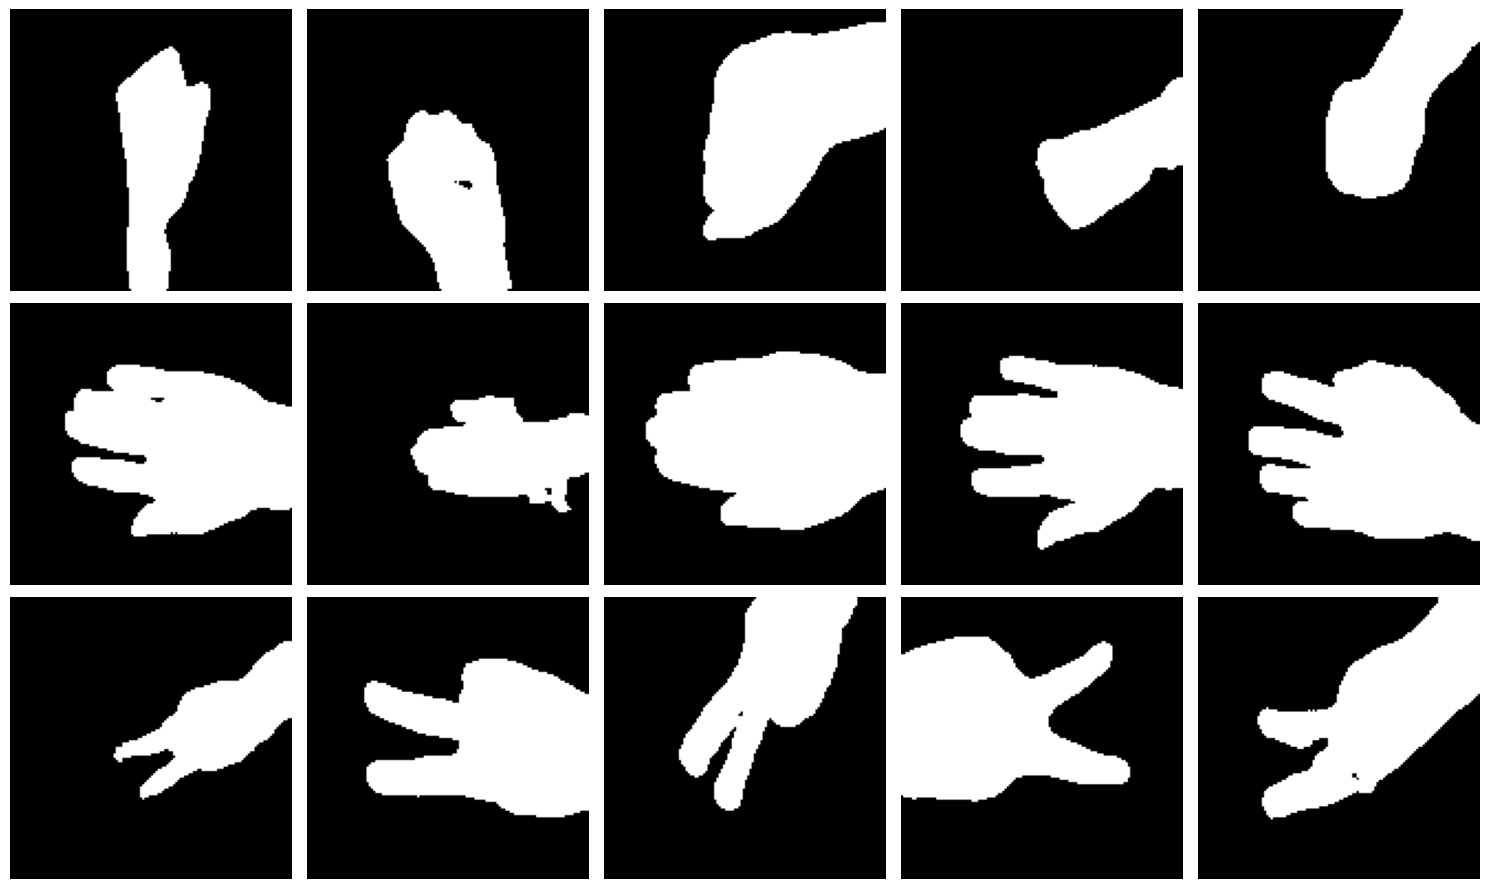

In [19]:
import random
import numpy as np
import os
import tensorflow as tf
from PIL import Image
from skimage.morphology import remove_small_holes, remove_small_objects, square


def load_masks(masks_dir, num_images=5):
    mask_files = os.listdir(masks_dir)
    random_files = random.sample(mask_files, min(num_images, len(mask_files)))
    masks = []
    for mask_file in random_files:
        mask_path = os.path.join(masks_dir, mask_file)
        mask = Image.open(mask_path)
        mask = np.array(mask)
        mask[mask == 255] = 1
        

        masks.append(mask)
        
    return masks

rock_masks = load_masks(os.path.join(DESTINATION_DIR, 'rock'))
paper_masks = load_masks(os.path.join(DESTINATION_DIR, 'paper'))
scissors_masks = load_masks(os.path.join(DESTINATION_DIR, 'scissors'))
all_masks = rock_masks + paper_masks + scissors_masks

def show_before_after(org_mask, processed_mask):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(org_mask, cmap='gray')
    axes[0].set_title("Original Mask")
    axes[1].imshow(processed_mask, cmap='gray')
    axes[1].set_title("Processed Mask")
    plt.tight_layout()
    plt.show()
def show_one_mask(mask):
    plt.imshow(mask, cmap='gray')
    plt.axis("off")
    plt.show()  
    
def show_all_before(masks):
    num_per_row = 5
    num_rows = int(np.ceil(len(masks) / num_per_row))

    fig, axes = plt.subplots(num_rows, num_per_row, figsize=(15, num_rows * 3))
    axes = np.array(axes).flatten()

    for i, mask in enumerate(masks):
        ax = axes[i]
        ax.imshow(mask, cmap='gray')
        ax.axis('off')

    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()
   
   
    
show_all_before(all_masks)


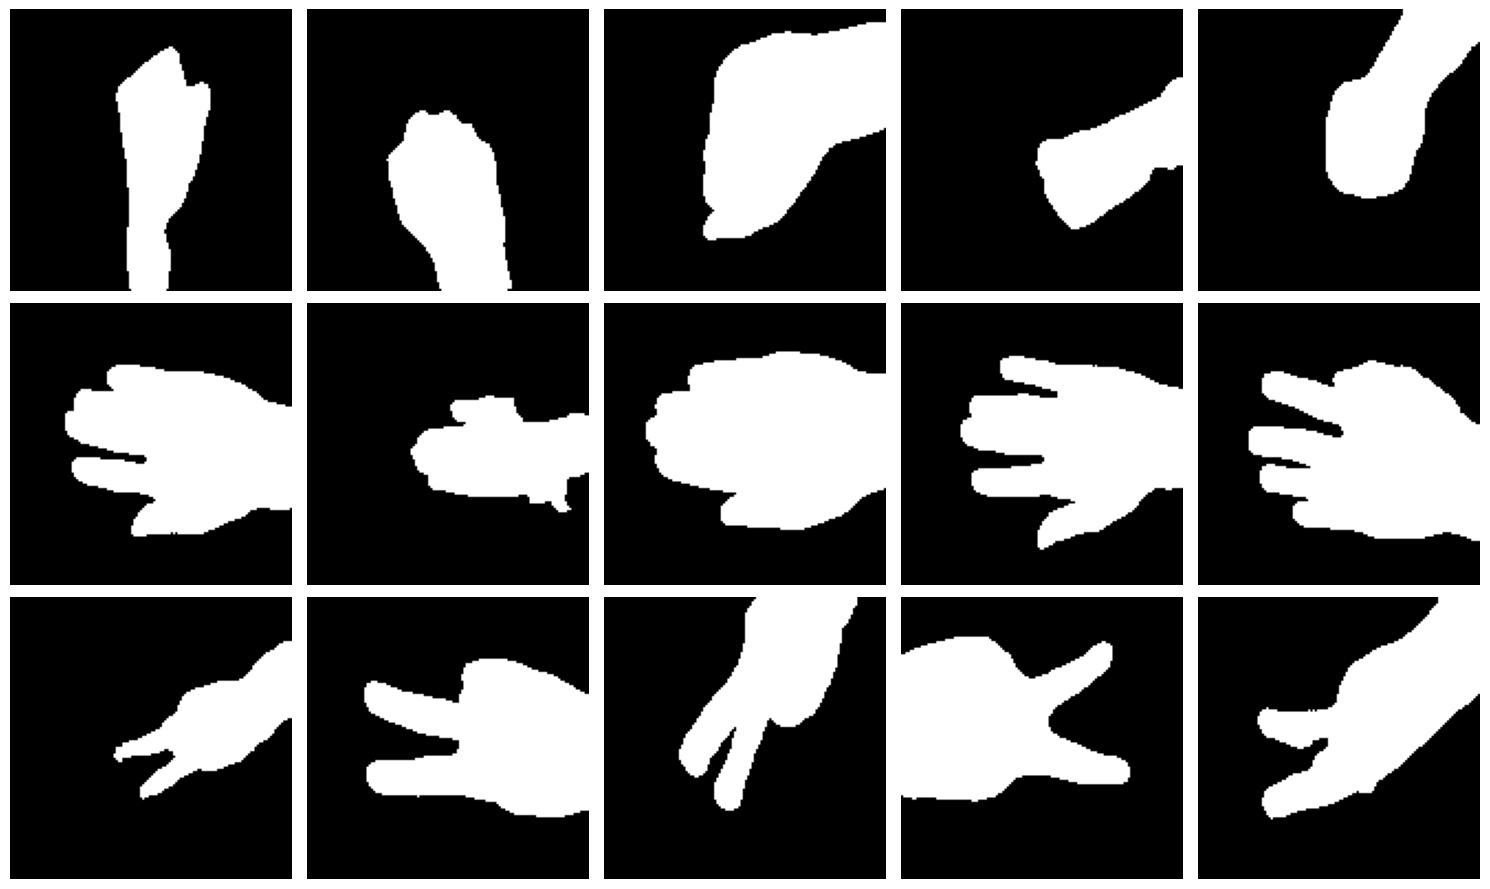

In [20]:
from skimage.morphology import remove_small_holes, remove_small_objects, square, disk, binary_closing

processed_masks = []
for mask in all_masks:
    mask_bool = mask.astype(bool)
    processed_mask = remove_small_objects(mask_bool, min_size=128)
    processed_mask = remove_small_holes(processed_mask, area_threshold=256)
    #processed_mask = binary_closing(processed_mask, disk(3))
    processed_masks.append(processed_mask)
show_all_before(processed_masks)

In [ ]:
PROCESSED_MASKS_DIR = './processed_masks'

